In [1]:
from scipy.integrate import cumtrapz

from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection

import h5py 

import sys
sys.path.append('/home/jannik/MA/fertige-MA/gitrepo')
from master_project import *

lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work
Loaded NRSur7dq4Remnant fit.
Loaded NRSur7dq4 model


### Configuration & Surrogate production

In [2]:
data = h5py.File('datafiles/BAMfiles/CF21_0033.h5', 'r')

In [3]:
for item in data['metadata'].attrs.items():
    print(item)

('LN-relaxed', array([0.00173128, 0.00740629, 0.66363327]))
('Mf', 0.9582575861605097)
('N', array([144., 144., 144., 144., 144., 192., 288., 408.,  96.,  96.,  96.,
        96.,  96.,  96.,  96.,  96.]))
('Norb', 10.20411055031946)
('Omega', 0.0225234183234544)
('S1-initial', array([0., 0., 0.]))
('S2-initial', array([ 8.03470e-06,  2.66666e-01, -6.25593e-04]))
('chi1-relaxed', array([-6.02823707e-05, -3.74380137e-05,  3.95955060e-04]))
('chi2-relaxed', array([-0.04528847,  0.59931323, -0.0035318 ]))
('chif', array([0.01176224, 0.19341806, 0.64052582]))
('d0', '58.03')
('eccentricity', 0.0006400468873515912)
('extraction-radii', array([ 50.,  60.,  70.,  80.,  90., 100., 120., 180.]))
('initial-adm-energy', 0.992015)
('mass1-initial', 0.333333)
('mass1-relaxed', 0.33320247772996237)
('mass2-initial', 0.666672)
('mass2-relaxed', 0.6661625136785623)
('max-levels-1', '13')
('max-levels-2', '12')
('mean-anomaly', 0.0)
('name', 'q2_A06T90')
('object-1', 'BH')
('object-2', 'BH')
('p1-initia

In [4]:
m1 = data['metadata'].attrs.get('mass1-relaxed')
m2 = data['metadata'].attrs.get('mass2-relaxed')

q = m2/m1

# orbital angular frequency at the relaxed time (divison by pi to get cyc/M)
Omega = data['metadata'].attrs.get('Omega')/(np.pi) 

# chi2 for NRSur7dq4 (lighter BH) at relaxed time
chi2 = data['metadata'].attrs.get('chi1-relaxed')

# chi1 for NRSur7dq4 (heavierer BH) at relaxed time
chi1 = data['metadata'].attrs.get('chi2-relaxed')

# time points
extraction_radius = 120
tortoise_radius = extraction_radius + 2*np.log(extraction_radius/2 - 1)
merger_time = data['metadata'].attrs.get('tM') + tortoise_radius
relaxed_time = data['metadata'].attrs.get('tR') + tortoise_radius
t_shift_NR = 10    # self-choosen shift

In [5]:
chix = 0.6 * np.sin(np.pi/2) * np.cos(np.pi/2)
chiy = 0.6 * np.sin(np.pi/2) * np.sin(np.pi/2)
chiz = 0.6 * np.cos(np.pi/2)
chi = [chix, chiy, chiz]

chi

[3.6739403974420595e-17, 0.6, 3.6739403974420595e-17]

In [6]:
# surrogate 
dt = 0.1      
f_low = 0
t_sur, h_iner, dyn = sur(q, chi1, chi2, dt=dt, f_low=f_low, f_ref=Omega, precessing_opts={'return_dynamics': True})
h_copr = modes_from_iner_to_new_frame(t_sur, h_iner, 'coprecessing')
h_coro = modes_from_iner_to_new_frame(t_sur, h_iner, 'corotating')

### Spin dynamics of NR data

In [7]:
# Extract spin on smaller black hole
t1 = np.array(data['horizon-data']['BH1']['t'])
S1 = np.array(data['horizon-data']['BH1']['spin'])

# Extract spin on larger black hole
t2 = np.array(data['horizon-data']['BH2']['t'])
S2 = np.array(data['horizon-data']['BH2']['spin'])
chi2_NR = S2/m2**2

retarded_merger_time = data['metadata'].attrs.get('tM')

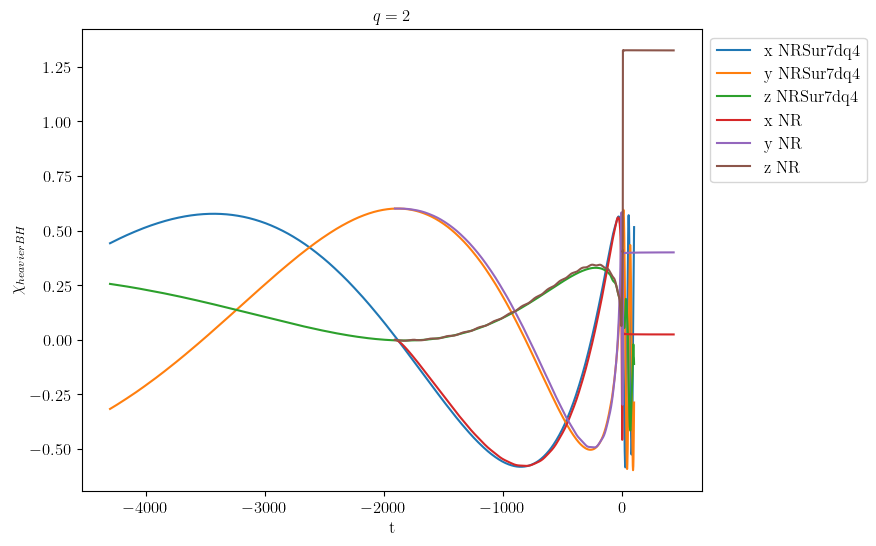

In [8]:
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(111)

ax1.plot(t_sur, dyn['chiA'][:,0], label='x NRSur7dq4')
ax1.plot(t_sur, dyn['chiA'][:,1], label='y NRSur7dq4')
ax1.plot(t_sur, dyn['chiA'][:,2], label='z NRSur7dq4')
ax1.plot( t2-retarded_merger_time, np.array(chi2_NR)[:,0], label='x NR' )
ax1.plot( t2-retarded_merger_time, np.array(chi2_NR)[:,1], label='y NR' )
ax1.plot( t2-retarded_merger_time, np.array(chi2_NR)[:,2], label='z NR' )
ax1.set_ylabel('$\chi_{heavier BH}$')
ax1.set_xlabel('t')
ax1.legend(bbox_to_anchor=(1, 1))
ax1.set_title('$q=%s$' %round(q))

plt.show()

### $h_{2,2}$ NR vs. NRSur7dq4

In [9]:
t_NR = np.array(data['psi4-data']['extraction-radius-120M']['(2,2)']['t'])
Re22 = np.array(data['psi4-data']['extraction-radius-120M']['(2,2)']['Re(psi4lm)'])
Im22 = np.array(data['psi4-data']['extraction-radius-120M']['(2,2)']['Im(psi4lm)'])

In [10]:
# my double Psi4 integration

def get_strain_from_psi4(psi4, t, tM):
    
    # calculate two integrals over psi4 with integration constants 0 
    drifted_strain = cumtrapz(cumtrapz(psi4, t, initial=0), t, initial=0)
    
    # get integration constant for first integral
    ringdown_idx = np.where(t > tM+300)
    dt = np.abs(t[1]-t[0])
    ringdown_slope = np.diff(drifted_strain[ringdown_idx]) / dt
    integration_constant = np.mean(ringdown_slope)

    # calculate non-drifted strain
    first_integral = cumtrapz(psi4, t, initial=0)
    second_integral = cumtrapz(first_integral-integration_constant, t, initial=0)
    
    # get intgration constant for second integral
    integration_constant_2 = np.mean(second_integral[ringdown_idx])

    return -second_integral + integration_constant_2


Re_h22 = get_strain_from_psi4(Re22, t_NR, merger_time)

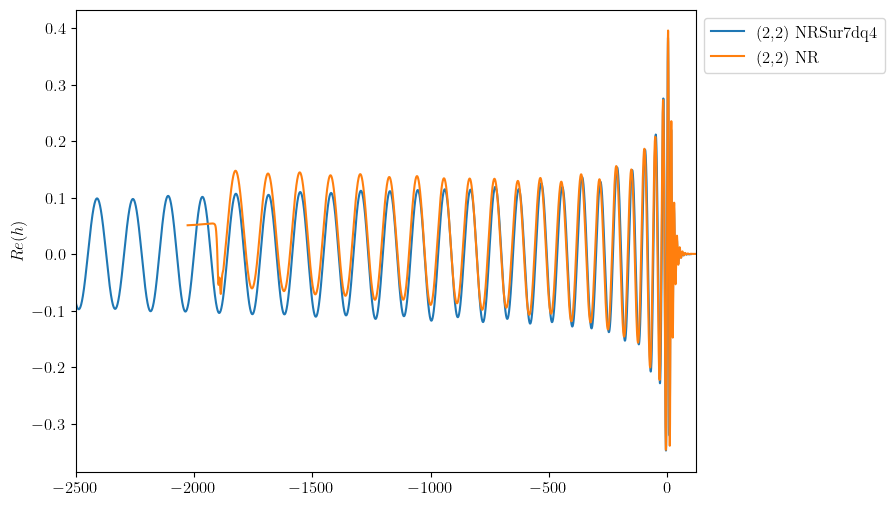

In [11]:
phase_factor_sur = 1 #np.exp(-1j*np.pi/2)

fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(111)

ax1.plot(t_sur, np.real(h_iner[2,2]*phase_factor_sur), label='(2,2) NRSur7dq4')
ax1.plot(t_NR - merger_time + t_shift_NR, Re_h22, label='(2,2) NR')
ax1.set_ylabel('$Re(h)$')
ax1.legend(bbox_to_anchor=(1, 1))
ax1.set_xlim(-2500,120)

plt.show()

### Momentum studies with NR, NRSur7dq4Remanant, NRSur7dq4/scri and Shrobana master equation 

In [12]:
# NR
t_radiation = data['radiated-linear-momenta']['extraction-radius-120M']['t']

dt_radiation = np.abs(t_radiation[1]-t_radiation[0])

dPxdt_NR = data['radiated-linear-momenta']['extraction-radius-120M']['dPxdt']
dPydt_NR = data['radiated-linear-momenta']['extraction-radius-120M']['dPydt']
dPzdt_NR = data['radiated-linear-momenta']['extraction-radius-120M']['dPzdt']

Px_t_NR = cumtrapz( dPxdt_NR, t_radiation, initial=0 )
Py_t_NR = cumtrapz( dPydt_NR, t_radiation, initial=0 )
Pz_t_NR = cumtrapz( dPzdt_NR, t_radiation, initial=0 )

Px_NR = simps(dPxdt_NR, dx=dt_radiation)
Py_NR = simps(dPydt_NR, dx=dt_radiation)
Pz_NR = simps(dPzdt_NR, dx=dt_radiation)

In [13]:
# NRSur7dq4Remnant
omega0 = Omega*np.pi
vf, vf_err = fit.vf(round(q), chi1, chi2, omega0=omega0) 
Px_NRSur7dq4Remnant = vf[0]
Py_NRSur7dq4Remnant = vf[1]
Pz_NRSur7dq4Remnant = vf[2]

Loaded NRSur7dq4 model


In [14]:
# scri WaveformModes
ell_min = 2
ell_max = 4

data_scri = list(h_iner.values())
data_scri = np.array(data_scri).T

waveform_modes = scri.WaveformModes(
                        dataType=scri.h,
                        t=t_sur,
                        data=data_scri,
                        ell_min=ell_min,
                        ell_max=ell_max,
                        frameType=scri.Inertial,
                        r_is_scaled_out=True,
                        m_is_scaled_out=True,
                        )

dPdt_scri = waveform_modes.momentum_flux()

Px_t_scri = cumtrapz( dPdt_scri[:,0], t_sur, initial=0 )
Py_t_scri = cumtrapz( dPdt_scri[:,1], t_sur, initial=0 )
Pz_t_scri = cumtrapz( dPdt_scri[:,2], t_sur, initial=0 )

Px_scri = simps(dPdt_scri[:,0], dx=dt)
Py_scri = simps(dPdt_scri[:,1], dx=dt)
Pz_scri = simps(dPdt_scri[:,2], dx=dt)

In [15]:
# Shrobana master equation

def momentum_from_waveform_asymmetries(h):
    
    # calculate quantities
    a = ampl_asym(h, 2, 2)
    phi_a = phi_asym(h, 2, 2)
    A = ampl_sym(h, 2, 2)
    phi_s = phi_sym(h, 2, 2)
    Phi = -phi_sym(h, 2, 2)/2         # dyn['orbphase'][:,] 
    
    # calculate derivates of quantities
    a_dot = np.diff(a) / dt
    a_dot = np.append(a_dot[0], a_dot)
    phi_a_dot = np.diff(phi_a) / dt 
    phi_a_dot = np.append(phi_a_dot[0], phi_a_dot)
    A_dot = np.diff(A) / dt 
    A_dot = np.append(A_dot[0], A_dot)
    phi_s_dot = np.diff(phi_s) / dt 
    phi_s_dot = np.append(phi_s_dot[0], phi_s_dot)
    
    # Shrobana master eq. and integration
    term1 = (a_dot*A_dot +a*A*phi_a_dot*phi_s_dot)*np.cos(phi_a - phi_s)
    term2 = - (a*A_dot*phi_a_dot -a_dot*A*phi_s_dot)*np.sin(phi_a - phi_s) 
    dPzdt = 1/(6*np.pi) * (term1 + term2)
    Pzt = cumtrapz( dPzdt, t_sur, initial=0 )
    Pz = simps(dPzdt, dx=dt)
    
    return term1, term2, dPzdt, Pzt, Pz


term1, term2, dPzdt_master, Pzt_master, Pz_master = momentum_from_waveform_asymmetries(h_copr)

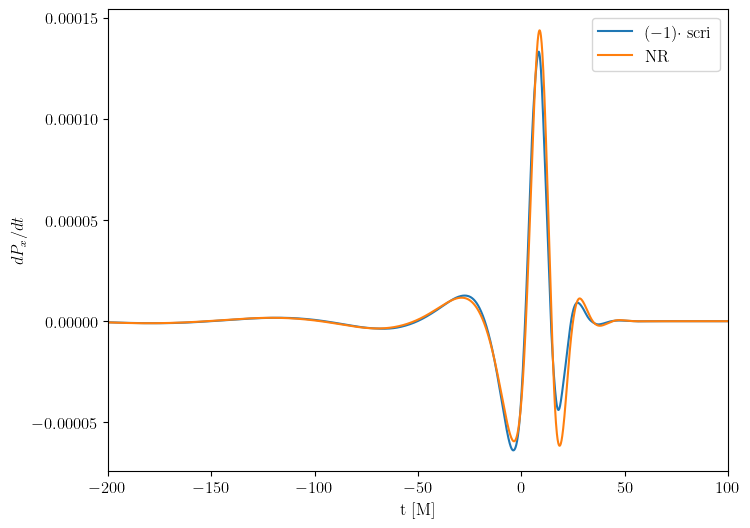

In [16]:
# plotting momentum flux in x-direction
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t_sur, dPdt_scri[:,0], label='$(-1)\cdot$ scri')
ax1.plot(t_radiation - merger_time + t_shift_NR, np.array(dPxdt_NR), label='NR')
ax1.set_ylabel('$dP_x/dt$')
ax1.set_xlabel('t [M]')
ax1.set_xlim(-200,100)
ax1.legend()
plt.show()

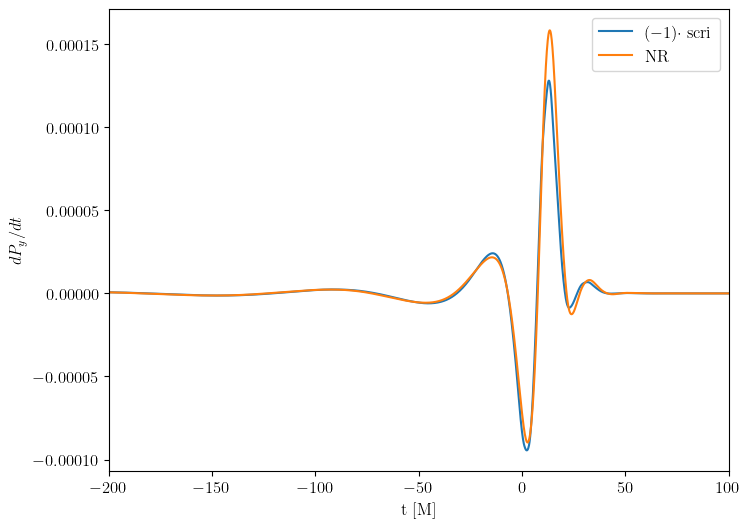

In [17]:
# plotting momentum flux in y-direction
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t_sur, dPdt_scri[:,1], label='$(-1)\cdot$ scri')
ax1.plot(t_radiation - merger_time + t_shift_NR, np.array(dPydt_NR), label='NR')
ax1.set_ylabel('$dP_y/dt$')
ax1.set_xlabel('t [M]')
ax1.set_xlim(-200,100)
ax1.legend()
plt.show()

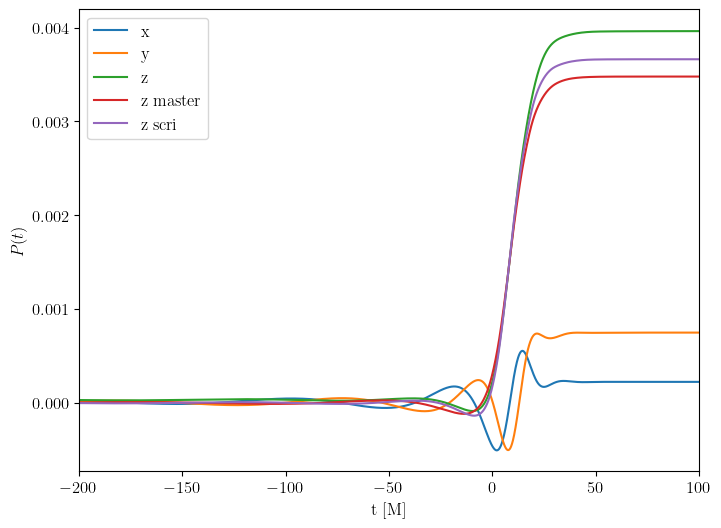

In [18]:
# plotting momentum time integration of NR
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t_radiation - merger_time + t_shift_NR, np.array(Px_t_NR), label='x')
ax1.plot(t_radiation - merger_time + t_shift_NR, np.array(Py_t_NR), label='y')
ax1.plot(t_radiation - merger_time + t_shift_NR, np.array(Pz_t_NR), label='z')
ax1.plot(t_sur, Pzt_master, label='z master')
ax1.plot(t_sur, Pz_t_scri, label='z scri')
ax1.set_ylabel('$P(t)$')
ax1.set_xlabel('t [M]')
ax1.set_xlim(-200,100)
ax1.legend()
plt.show()

In [19]:
in_km_s = 3*10**5
print('   -x-   ')
print('NR:               ', Px_NR*in_km_s)
print('(-1) scri:        ', -Px_scri*in_km_s)
print('NRSur7dq4Remnant: ', Px_NRSur7dq4Remnant*in_km_s)

   -x-   
NR:                66.93649868943429
(-1) scri:         -73.83556807784973
NRSur7dq4Remnant:  -95.26182794496158


In [20]:
print('   -y-   ')
print('NR:               ', Py_NR*in_km_s)
print('(-1) scri:        ', -Py_scri*in_km_s)
print('NRSur7dq4Remnant: ', Py_NRSur7dq4Remnant*in_km_s)

   -y-   
NR:                224.91043088131576
(-1) scri:         -136.44445087367626
NRSur7dq4Remnant:  -155.22193605125057


In [21]:
print('   -z-   ')
print('NR:               ', Pz_NR*in_km_s)
print('NR vR:            ', data['metadata'].attrs.get('vR'))
print('(-1) master:      ', -Pz_master*in_km_s)
print('(-1) scri:        ', -Pz_scri*in_km_s)
print('NRSur7dq4Remnant: ', Pz_NRSur7dq4Remnant*in_km_s)

   -z-   
NR:                1191.0573303301762
NR vR:             1267.2122744539229
(-1) master:       -1043.2880590550612
(-1) scri:         -1098.6421014967077
NRSur7dq4Remnant:  -1116.252562055124


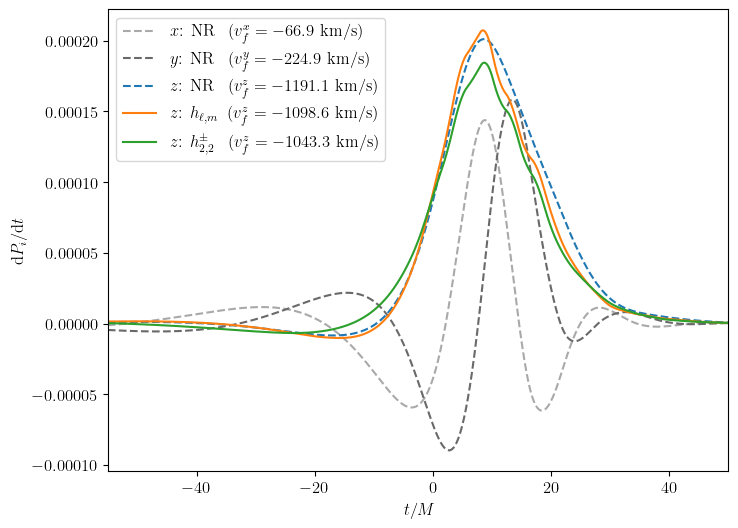

In [22]:
# plotting momentum flux in all directions
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(t_radiation - merger_time + t_shift_NR, np.array(dPxdt_NR), '--', 
         label='$x$: NR $\,$ ($v^x_{f} = %.1f$ km/s)' %(-Px_NR*in_km_s), color='darkgrey')
ax1.plot(t_radiation - merger_time + t_shift_NR, np.array(dPydt_NR), '--', 
         label='$y$: NR $\,$ ($v^y_{f} = %.1f$ km/s)' %(-Py_NR*in_km_s), color='dimgray')
ax1.plot(t_radiation - merger_time + t_shift_NR, np.array(dPzdt_NR), '--', 
         label='$z$: NR $\,$ ($v^z_{f} = %.1f$ km/s)' %(-Pz_NR*in_km_s))
ax1.plot(t_sur, dPdt_scri[:,2], 
         label=r'$z$: $h_{\ell,m}\:$ ($v^z_{f} = %.1f$ km/s)' %(-Pz_scri*in_km_s))
ax1.plot(t_sur, dPzdt_master, 
         label=r'$z$: $h^\pm_{2,2}$ $\,$ ($v^z_{f} = %.1f$ km/s)' %(-Pz_master*in_km_s)) 
ax1.set_ylabel(r'$\mathrm{d}P_i/\mathrm{d}t$')
ax1.set_xlabel(r'$t/M$')
ax1.set_xlim(-55,50)
ax1.legend(loc='upper left')


#fig.savefig('dpzdpt_q2_A06T90.pdf')
plt.show()

### Center-of mass trajectory

In [23]:
# Extract black holes positions
r1 = data['moving-puncture-data']['BH1']['position']
r2 = data['moving-puncture-data']['BH2']['position']

com = m1*r1 + m2*r2

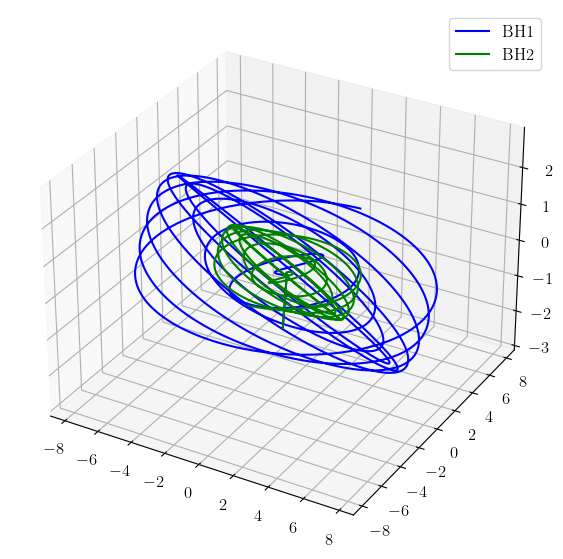

In [24]:
ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.plot(r1[0], r1[1], r1[2], 'b-', label='BH1' )
ax.plot(r2[0], r2[1], r2[2], 'g-', label='BH2' )
plt.legend(loc='best')
plt.show()

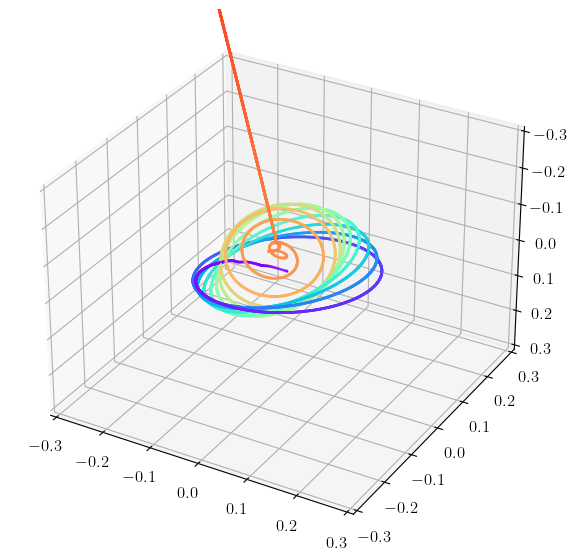

In [25]:
ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
dim3 = range(len(com[0]))
ax.scatter(com[0], com[1], com[2] ,cmap='rainbow', c=dim3, s=1)
ax.set_xlim(-.3,.3)
ax.set_ylim(-.3,.3)
ax.set_zlim(.3,-.3)
plt.show()

In [26]:
# cut moving puncture data in range tstart to tend

tstart = -1000
tend = 200

t_mpd = data['moving-puncture-data']['BH1']['t'] 
t_mpd_shifted = np.array(t_mpd - merger_time + t_shift_NR)
idx0 = np.argmin(np.abs(t_mpd_shifted - tstart))
idxf = np.argmin(np.abs(t_mpd_shifted - tend))

t_cutted = t_mpd_shifted[idx0:idxf]
comx, comy, comz = com[0][idx0:idxf], com[1][idx0:idxf], com[2][idx0:idxf]

print(t_mpd_shifted[idx0])
print(t_mpd_shifted[idxf])

-999.956730776225
199.97219500502524


In [27]:
# cut surogate data in range tstart to tend

idx0_sur = np.argmin(np.abs(t_sur - tstart))
idxf_sur = np.argmin(np.abs(t_sur - tend))

t_cutted_sur = t_sur[idx0_sur:idxf_sur]
re22sym = np.real(h_sym(h_iner, 2, 2))[idx0_sur:idxf_sur]
re22asym = np.real(h_asym(h_iner, 2, 2))[idx0_sur:idxf_sur]

print(t_sur[idx0_sur])
print(t_sur[idxf_sur])

-999.999999996804
100.00000000319596


In [28]:
# legend class
class HandlerColorLineCollection(HandlerLineCollection):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize,trans):
        x = np.linspace(0,width,self.get_numpoints(legend)+1)
        y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=artist.cmap,
                     transform=trans)
        lc.set_array(x)
        lc.set_linewidth(artist.get_linewidth())
        return [lc]

In [51]:
size = 17

params = {'xtick.labelsize' : size, 
          'ytick.labelsize' : size, 
          'axes.labelsize' : size, 
          'legend.fontsize' : size, 
          'font.size' : size,
          'axes.titlesize': size
         }
plt.rcParams.update(params)

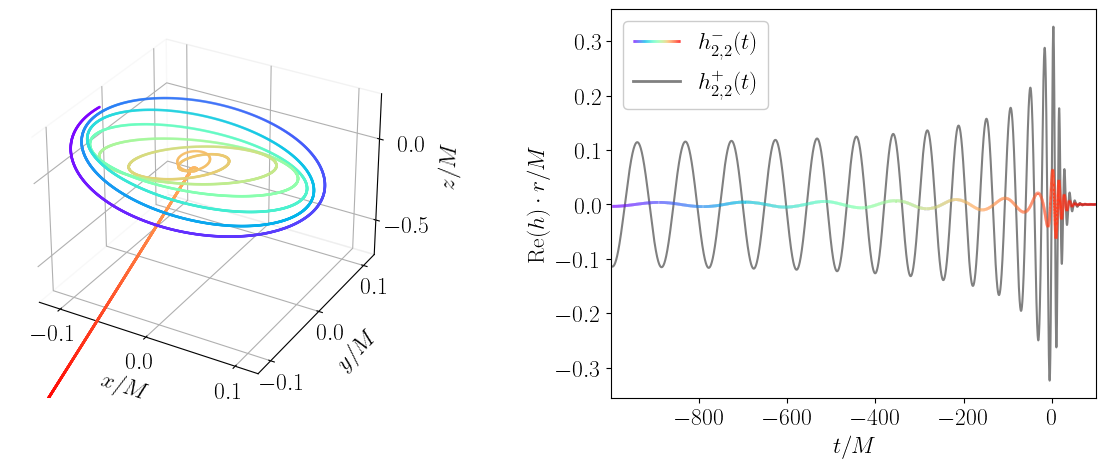

In [64]:
# setup plotting
fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
 
# com plot
dim3 = range(len(t_cutted))
ax1.scatter(comx, comy, comz, cmap='rainbow', c=dim3, s=0.75, rasterized=True)
ax1.set_xlim(-.12,.12)
ax1.set_ylim(-.12,.12)
ax1.set_zlim(-.7,.25)
ax1.set_xlabel(r"$x/M$")
ax1.set_ylabel(r"$y/M$")
ax1.set_zlabel(r"$z/M$", labelpad=11)
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
ax1.tick_params(axis='x', which='both', pad=-.5)
ax1.tick_params(axis='y', which='both', pad=-.5)
ax1.tick_params(axis='z', which='both', pad= 6)
ax1.locator_params(nbins=3, axis='x')
ax1.locator_params(nbins=3, axis='y')
ax1.locator_params(nbins=3, axis='z')

# strain plot
# plotting real part of symmetric waveform
ax2.plot(t_cutted_sur, re22sym, color='grey')
ax2.set_xlim(-999, 100)

# plotting real part of anti-symmetric waveform 
points = np.array([t_cutted_sur, re22asym]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='rainbow', rasterized=True)
lc.set_array(t_cutted_sur)
lc.set_linewidth(2)
ax2.add_collection(lc)

# plot beautification
ax2.set_ylabel('Re$(h)\cdot r/M$')
ax2.set_xlabel('$t/M$')
plot_line = Line2D([], [], color='grey', linewidth=2)
ax2.legend([lc, plot_line], ['$h_{2,2}^-(t)$', '$h_{2,2}^+(t)$'],\
    handler_map={lc: HandlerColorLineCollection(numpoints=100)}, framealpha=1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=50, hspace=None)
fig.tight_layout()
#fig.savefig('com.pdf')
plt.show()